# Solving a HANK and SAM model with HARK

by William Du (wdu9@jhu.edu)

In [1]:


from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
import time
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import sparse as sp
from HARK.distribution import DiscreteDistribution, MeanOneLogNormal,combine_indep_dstns,Lognormal, Uniform,DiscreteDistributionLabeled
from HARK.utilities import Fake_News_JAC



In [2]:
class HANK_SAM_Agent(MarkovConsumerType):
    
    def calc_jacobian(self,shk_param,T,ntrl_msr):
        
        params = deepcopy(self.__dict__["parameters"])        
        params['T_cycle'] = T
        params['LivPrb'] = params['T_cycle']*self.LivPrb
        params['PermGroFac'] = params['T_cycle']*self.PermGroFac
        params['PermShkStd'] = params['T_cycle']*self.PermShkStd
        params['TranShkStd'] = params['T_cycle']*self.TranShkStd
        params['Rfree'] = params['T_cycle']*self.Rfree
        params['MrkvArray'] = params['T_cycle']*self.MrkvArray
        params['cycles'] = 1
        
        jac_agent = MarkovConsumerType(**params)
        jac_agent.cycles = 1
        jac_agent.del_from_time_inv('Rfree')
        jac_agent.add_to_time_vary('Rfree')
        jac_agent.IncShkDstn = params['T_cycle'] * self.IncShkDstn

        jac_agent.solution_terminal.cFunc = deepcopy(self.solution[0].cFunc) 
        jac_agent.solution_terminal.vFunc = deepcopy(self.solution[0].vFunc)
        jac_agent.solution_terminal.vPfunc = deepcopy(self.solution[0].vPfunc)
        jac_agent.solution_terminal.vPPfunc = deepcopy(self.solution[0].vPPfunc)
        jac_agent.dstn_0 = self.prb_dstn
        
        PermShkDstn = MeanOneLogNormal(self.PermShkStd[0],123)._approx_equiprobable(self.PermShkCount)
        PermShk_ntrl_msr = deepcopy(PermShkDstn)
        PermShk_ntrl_msr.pmv = PermShk_ntrl_msr.atoms[0]*PermShk_ntrl_msr.pmv[0]
        
        dx = .0001
        q = params['T_cycle'] - 1
        
        if shk_param =='job_find':
            
            MrkvArray_dx = np.array( [ [1 - self.job_sep*(1-(self.job_find + dx)) , self.job_find + dx] ,  #" The sum of entries in each column in t should equal one. "

                                           [self.job_sep*(1- (self.job_find +dx) ), 1 -( self.job_find +dx) ] ]  ).T

            eigen, ssdx_dstn = sp.linalg.eigs(MrkvArray_dx.T , k=1, which='LM') # transposed to have columns sum up to one
            ssdx_dstn = ssdx_dstn[:,0] / np.sum(ssdx_dstn[:,0])

            jac_agent.MrkvArray = q*self.MrkvArray + [MrkvArray_dx] + (params['T_cycle'] - q  )*self.MrkvArray

            ntrl_msr = params['T_cycle']*[IncShkDstn_ntrl_msr]
            
            
        elif shk_param =='wage':
            
            #employed Income shock distribution
            TranShkDstn_W = MeanOneLogNormal(self.TranShkStd[0],123)._approx_equiprobable(self.TranShkCount)
            TranShkDstn_W.atoms  = TranShkDstn_W.atoms*(self.wage+dx)*(1-(self.tau) )
            employed_IncShkDstnW1 = combine_indep_dstns(PermShkDstn,TranShkDstn_W)
            
            employed_IncShkDstnW = DiscreteDistributionLabeled.from_unlabeled(
                employed_IncShkDstnW1,
                name="Distribution of Shocks to Income",
                var_names=["PermShk", "TranShk"],
            )
            # Perturbed Neutral Measure
            IncShkDstn_ntrl_msr_eW = combine_indep_dstns(PermShk_ntrl_msr,TranShkDstn_W)
            IncShkDstn_ntrl_msr_W = [IncShkDstn_ntrl_msr_eW,IncShkDstn_ntrl_msr[1]]
            
            jac_agent.IncShkDstn = q*self.IncShkDstn + [ [employed_IncShkDstnW, self.IncShkDstn[0][1]] ]  + (params['T_cycle'] - q  )*self.IncShkDstn
            ntrl_msr = q*[IncShkDstn_ntrl_msr] + [IncShkDstn_ntrl_msr_W] + (params['T_cycle'] - q )*[IncShkDstn_ntrl_msr]

            
        elif shk_param == 'tau':
            
            # Tau shock(tax rate)
            TranShkDstn_e_tau = MeanOneLogNormal(self.TranShkStd[0],123)._approx_equiprobable(self.TranShkCount)
            TranShkDstn_e_tau.atoms  = TranShkDstn_e_tau.atoms*(self.wage)*(1-(self.tau + dx) )
            employed_IncShkDstn_tau1 = combine_indep_dstns(PermShkDstn,TranShkDstn_e_tau)

            employed_IncShkDstn_tau = DiscreteDistributionLabeled.from_unlabeled(
                employed_IncShkDstn_tau1,
                name="Distribution of Shocks to Income",
                var_names=["PermShk", "TranShk"],
            )
            # Perturbed Neutral Measure
            IncShkDstn_ntrl_msr_e_tau = combine_indep_dstns(PermShk_ntrl_msr,TranShkDstn_e_tau)
            IncShkDstn_ntrl_msr_tau = [IncShkDstn_ntrl_msr_e_tau,IncShkDstn_ntrl_msr[1]]
            
            jac_agent.IncShkDstn = q*self.IncShkDstn + [ [employed_IncShkDstn_tau, self.IncShkDstn[0][1] ] ]  + (params['T_cycle'] - q  )*self.IncShkDstn 
            ntrl_msr = q*[IncShkDstn_ntrl_msr] + [IncShkDstn_ntrl_msr_tau] + (params['T_cycle'] - q )*[IncShkDstn_ntrl_msr]

        elif shk_param == 'Rfree':
            
            jac_agent.Rfree = q*self.Rfree + [self.Rfree[0] + dx] + (params['T_cycle'] - q )*self.Rfree
            ntrl_msr = params['T_cycle']*[IncShkDstn_ntrl_msr]

            
        jac_agent.solve()
        jac_agent.define_distribution_grid(dist_pGrid = params['T_cycle']*[np.array([1])])
        jac_agent.calc_transition_matrix(ntrl_msr) 
        
        
        jac_agent.aPol_Grid.append(self.aPol_Grid)
        jac_agent.cPol_Grid.append(self.cPol_Grid)

        
        a_t = []
        c_t = []

        for i in range(jac_agent.state_num):

            a_t_i = []
            c_t_i = []

            for t in range(params['T_cycle'] + 1):
                a_t_i.append(jac_agent.aPol_Grid[t][i])
                c_t_i.append(jac_agent.cPol_Grid[t][i])

            a_t.append(a_t_i)
            c_t.append(c_t_i)


        tran_mat = []
        for i in range(jac_agent.state_num):
            tran_mat_i = []
            for t in range(params['T_cycle']):

                tran_mat_i.append(jac_agent.tran_matrix[t][i])
            tran_mat.append(tran_mat_i)

        CJAC = np.zeros((T,T))
        AJAC = np.zeros((T,T))

        for i in range(self.state_num):
            CJAC_i, AJAC_i = Fake_News_JAC(self.aPol_Grid[i],self.cPol_Grid[i],a_t[i],c_t[i],self.tran_matrix[i],tran_mat[i],self.vec_erg_dstns[i].T, dx, T) # Calculate Jacobian matrices with fake news algorithm
            
            CJAC += self.prb_dstn[i]*CJAC_i
            AJAC += self.prb_dstn[i]*AJAC_i

            
        return CJAC, AJAC
    
    

# Steady State Parameters

In [3]:

#Parameters
job_sep =.1
unemp_insurance = .5
vacancy_fil_rate = .71
phi = vacancy_fil_rate
job_find = .657
phi_ss = phi
Z_ss = 1.209
R = 1.02**.25 # as you raise the interest rate,  the target level of assets falls and so the discount factor falls and the AIC, this amplifies the mutliplier
r_ss = R - 1

alpha = .6
chi = (vacancy_fil_rate/job_find**(alpha/(alpha -1)))**(-(alpha-1))
phi = job_find**(alpha/(alpha - 1))  * chi**(-1/(alpha-1)) #Making sure this is equal to vacancy fill rate
          
delta = ((R**4)*(1-(1/5)) )**(1/4) # or you can do delta = R*(1 -(1/20)), 20 quarters is 5 years
qb_ss = (1) / (R - delta)
print(job_find)



markov_array = np.array( [ [1 - job_sep*(1-job_find) ,  job_find ] ,  #" The sum of entries in each column in t should equal one. "
                          
                
                          [ job_sep*(1-job_find) , 1- job_find] ]          )

eigen, ss_dstn = sp.linalg.eigs(markov_array , k=1, which='LM')


print('markov array' , markov_array)


ss_dstn = ss_dstn[:,0] / np.sum(ss_dstn[:,0]) # Steady state distribution of employed/unemployed 

print('ss_dstn', ss_dstn)


#SS Labor
N_ss = 1 - (markov_array[1][0] / (markov_array[0][1] + markov_array[1][0])) # Note this happens to equal to the proportion of individuals who are employed


#SS vacancy
v_ss = N_ss*job_sep / phi


#MC 
epsilon_p = 6 # Elasticity of substitution 

MC_ss = (epsilon_p - 1) /epsilon_p
Y_ss = Z_ss*N_ss

wage_ss = 1.0

kappa = (MC_ss*Z_ss - wage_ss) / ( (1/phi) - (1/R)*(1-job_sep)/phi )  


print( 'kappa/(wage*phi):', kappa/(wage_ss*phi) )
print( 'kappa', kappa )

D_ss = Z_ss*N_ss* (1-MC_ss)
G_ss = Y_ss*.2 # 20 percent of output


A_ss = 4.526270936228729 # Aggregate Liquid Wealth to Quarterly Permanent Income 
B_ss = A_ss/qb_ss

#A_ss = qb_ss*B_ss + q_ss

tau_ss = (G_ss  + unemp_insurance*(1-N_ss)  - ( 1 + delta*qb_ss - qb_ss)*B_ss )/(wage_ss*N_ss)
print('tau_ss' , tau_ss)

# Steady State Consumption Target
C_ss = wage_ss*N_ss - G_ss 
print( 'Consumption Target: ' + str(C_ss) )


# Steady State Asset Target 

print( 'Asset Target: ' +str(A_ss) )

q_ss = D_ss/(R-1)

print('Government bonds to GDP', qb_ss*B_ss / Y_ss)
print('Liquid Assets to output ratio', A_ss/(Y_ss))

print(' Aggregate Liquidity to annual output ratio', A_ss/(4*Y_ss))

print('Liquids Assets to after tax labor Income Ratio', A_ss/(wage_ss*N_ss*(1-tau_ss)))


0.657
markov array [[0.9657 0.657 ]
 [0.0343 0.343 ]]
ss_dstn [0.95038334 0.04961666]
kappa/(wage*phi): 0.07180841725578556
kappa 0.05098397625160775
tau_ss 0.24426717203617027
Consumption Target: 0.7205806451612903
Asset Target: 4.526270936228729
Government bonds to GDP 3.939267138036165
Liquid Assets to output ratio 3.939267138036165
 Aggregate Liquidity to annual output ratio 0.9848167845090412
Liquids Assets to after tax labor Income Ratio 6.30192813340863


/opt/anaconda3/envs/Update_HARK_01_28_2023/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [4]:




states = 2

HANK_SAM_Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2.0,                            # Coefficient of relative risk aversion
    "Rfree": [np.array([R]* states)],      # Interest factor on assets
    "DiscFac": .96,                  # Intertemporal discount factor
    "LivPrb" : [np.array([.99375]*states)],                # Survival probability
    "PermGroFac" : [np.array([1.00]*states)],               # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.00001,                   # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 160000000,                     # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 200,                    # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 100000,                 # Number of agents of this type
    "T_sim" : 200,                         # Number of periods to simulate
    "aNrmInitMean" : np.log(.8)-(.5**2)/2, # Mean of log initial assets
    "aNrmInitStd"  : .5,                   # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
    # new parameters
     "job_sep"    : job_sep, 
     "job_find"   : job_find, 
     
    # markov array
    "MrkvArray"   :  [ np.array( [ [1 - job_sep*(1-job_find) , job_find ] ,  
                          
                               [ job_sep*(1-job_find) , 1- job_find] ]          ).T ],
    
        
    "MrkvArray_real"   :  [ np.array( [ [1 - job_sep*(1-job_find) , job_find ] ,  
                          
                               [ job_sep*(1-job_find) , 1- job_find] ]          ).T ],
    
    "mMin": 1e-5 ,
    "mMax": 1000000 , 
    "mCount": 300 , 
    "mFac": 3, 
    
     }

In [5]:

HANK_SAM_Dict['MrkvArray'] = [ np.array( [ [1 - HANK_SAM_Dict['job_sep']*(1-HANK_SAM_Dict['job_find']) , HANK_SAM_Dict['job_find'] ] ,  
                          
                               [ HANK_SAM_Dict['job_sep']*(1-HANK_SAM_Dict['job_find']) , 1- HANK_SAM_Dict['job_find']] ]          ).T ]


example = HANK_SAM_Agent(**HANK_SAM_Dict,verbose=True)

example.cycles = 0
example.T_cycles = 1
example.wage = wage_ss
example.unemp_insurance = unemp_insurance
rfree = example.Rfree
example.tau = tau_ss
example.del_from_time_inv('Rfree')
example.add_to_time_vary('Rfree')

#Income shock distributions for each markov state

TranShkDstn_e = MeanOneLogNormal(example.TranShkStd[0],123)._approx_equiprobable(example.TranShkCount)
TranShkDstn_e.atoms  = TranShkDstn_e.atoms*example.wage*(1-example.tau)


TranShkDstn_u1 = MeanOneLogNormal(example.TranShkStd[0],123)._approx_equiprobable(example.TranShkCount)
TranShkDstn_u1.atoms  = TranShkDstn_u1.atoms*example.unemp_insurance

PermShkDstn = MeanOneLogNormal(example.PermShkStd[0],123)._approx_equiprobable(example.PermShkCount)
PermShkDstn_u = deepcopy(PermShkDstn)

#employed Income shock distribution
employed_IncShkDstn_1 = combine_indep_dstns(PermShkDstn,TranShkDstn_e)

#unemployed Income shock distribution
unemployed_IncShkDstn_1 = combine_indep_dstns(PermShkDstn_u,TranShkDstn_u1)

# Transform Distributions into Labeled Distributions
employed_IncShkDstn = DiscreteDistributionLabeled.from_unlabeled(
    employed_IncShkDstn_1,
    name="Distribution of Shocks to Income",
    var_names=["PermShk", "TranShk"],
)

unemployed_IncShkDstn = DiscreteDistributionLabeled.from_unlabeled(
    unemployed_IncShkDstn_1,
    name="Distribution of Shocks to Income",
    var_names=["PermShk", "TranShk"],
)

# Income Shock Distributions as attributes of the example Agent
example.IncShkDstn = [ [employed_IncShkDstn, unemployed_IncShkDstn] ]



# Neutral Measure (Harmenberg 2021)

In [6]:
PermShkDstn_u = MeanOneLogNormal(example.PermShkStd[0] ,123)._approx_equiprobable(example.PermShkCount)

PermShk_ntrl_msr = deepcopy(PermShkDstn)
PermShk_ntrl_msr.pmv = PermShk_ntrl_msr.atoms[0]*PermShk_ntrl_msr.pmv[0]
IncShkDstn_ntrl_msr_e = combine_indep_dstns(PermShk_ntrl_msr,TranShkDstn_e)

PermShk_ntrl_msr_u = deepcopy(PermShkDstn_u) #change permshkdstn to institute increase in variance or not
PermShk_ntrl_msr_u.pmv = PermShk_ntrl_msr_u.atoms[0]*PermShk_ntrl_msr_u.pmv[0]
IncShkDstn_ntrl_msr_u1 = combine_indep_dstns(PermShk_ntrl_msr_u,TranShkDstn_u1)

IncShkDstn_ntrl_msr = [IncShkDstn_ntrl_msr_e,IncShkDstn_ntrl_msr_u1 ]



# Specify Agents

In [7]:
BaselineType = deepcopy(example) 
BaselineType.IncShkDstn = [ [employed_IncShkDstn, unemployed_IncShkDstn] ]
BaselineType.cycles = 0
BaselineType.mCount = 300


# Specify the distribution of the discount factor
num_types = 7 # number of types we want

DiscFac_mean =  0.9786919599273968# center of beta distribution
DiscFac_spread =   0.024077275992363603 # spread of beta distribution


DiscFac_dstn = (
        Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
        ._approx_equiprobable(num_types)
        .atoms.flatten()
    )
MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)


# Solve for Jacobians

In [8]:
start = time.time()

CJAC_JF_list = []
AJAC_JF_list = []

CJACR_list = []
AJACR_list = []

CJACW_list = []
AJACW_list = []


CJAC_tau_list = []
AJAC_tau_list = []

C_steady_state = 0
A_steady_state = 0

for i in range(len(MyTypes)):
    
    HANK_SAM_Dict['DiscFac'] = DiscFac_dstn[i]

    ThisType = HANK_SAM_Agent(**HANK_SAM_Dict,verbose=True)
    ThisType.cycles = 0
    ThisType.del_from_time_inv('Rfree')
    ThisType.add_to_time_vary('Rfree')
    ThisType.T_cycles = 1
    rfree = example.Rfree
    ThisType.wage = wage_ss
    ThisType.tau = tau_ss
    
    ThisType.IncShkDstn = [ [employed_IncShkDstn, unemployed_IncShkDstn] ]
    
    C_ss_thistype, A_ss_thistype = ThisType.compute_steady_state(IncShkDstn_ntrl_msr)
    C_steady_state += (1/num_types)*C_ss_thistype
    A_steady_state += (1/num_types)*A_ss_thistype
    
    
    T = 300
    CJAC_JF_this_type, AJAC_JF_this_type = ThisType.calc_jacobian('job_find',T,IncShkDstn_ntrl_msr)
    CJACW_this_type, AJACW_this_type = ThisType.calc_jacobian('wage',T,IncShkDstn_ntrl_msr)
    CJAC_tau_this_type, AJAC_tau_this_type = ThisType.calc_jacobian('tau',T,IncShkDstn_ntrl_msr)
    CJACR_this_type, AJACR_this_type = ThisType.calc_jacobian('Rfree',T,IncShkDstn_ntrl_msr)
    

    CJAC_JF_list.append(CJAC_JF_this_type)
    AJAC_JF_list.append(AJAC_JF_this_type)

    CJACR_list.append(CJACR_this_type)
    AJACR_list.append(AJACR_this_type)

    CJACW_list.append(CJACW_this_type)
    AJACW_list.append(AJACW_this_type)

    CJAC_tau_list.append(CJAC_tau_this_type)
    AJAC_tau_list.append(AJAC_tau_this_type)
    
print('time taken to solve jacobians' , time.time() - start)

    
    

/opt/anaconda3/envs/Update_HARK_01_28_2023/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


time taken to solve jacobians 126.14053106307983


In [9]:
print(C_steady_state)
print(A_steady_state)

0.7370690342123284
4.533165110492943


In [10]:
def compute_weighted_average(JAC_list):
    
    JAC = np.zeros_like(JAC_list[0])
    for i in range(len(JAC_list)):
        JAC += (1/num_types)*JAC_list[i]
        
    return JAC


CJAC_tau = compute_weighted_average(CJAC_tau_list)
AJAC_tau = compute_weighted_average(AJAC_tau_list)

CJAC_JF = compute_weighted_average(CJAC_JF_list)
AJAC_JF = compute_weighted_average(AJAC_JF_list)

CJACR = compute_weighted_average(CJACR_list)
AJACR = compute_weighted_average(AJACR_list)

CJACW = compute_weighted_average(CJACW_list)
AJACW =  compute_weighted_average(AJACW_list)

# Tax Jacobians

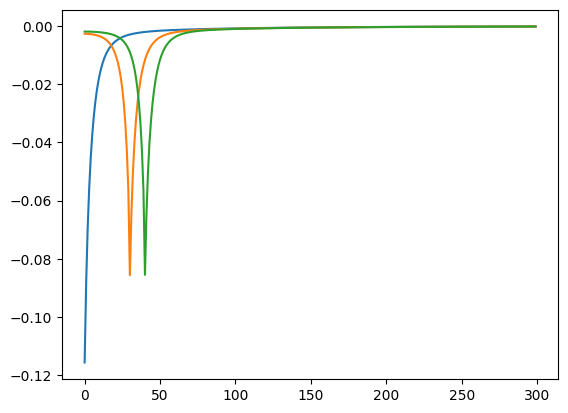

In [11]:
plt.plot(CJAC_tau.T[0])
plt.plot(CJAC_tau.T[30])
plt.plot(CJAC_tau.T[40])
plt.show()

# Job Finding Jacobians

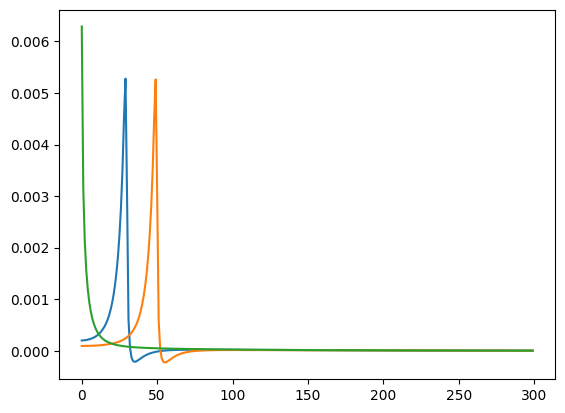

In [12]:
plt.plot(CJAC_JF.T[30])
plt.plot(CJAC_JF.T[50])
plt.plot(CJAC_JF.T[0])
plt.show()

# Interest Rate Jacobians

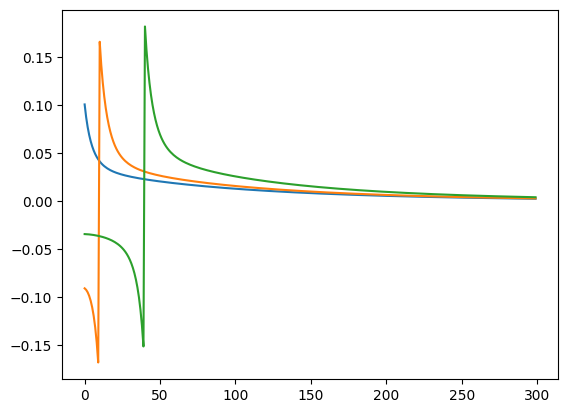

In [13]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[40])
plt.show()

# Wage Jacobians

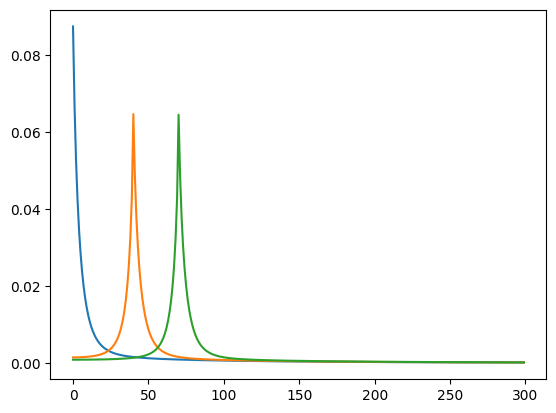

In [14]:
plt.plot(CJACW.T[0])
plt.plot(CJACW.T[40])
plt.plot(CJACW.T[70])
plt.show()

# Solving for Impulse Responses

In [15]:
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

# Specify General Equilibrium Equations

In [16]:

"""
ndur =  .75
duration = 1/(1-ndur)
print(duration)
varphi = (epsilon_p - 1)*ndur / ( (1-ndur)*(1-example.DiscFac*ndur) )
"""

varphi = 10*epsilon_p
print('slope of phillips curve', epsilon_p/varphi)

rho_r =.0
phi_b = .1
phi_pi = 1.5
phi_y = .1

pi_ss =0

@sj.simple
def unemployment(N):
    
    U = 1 - N
    
    return U


LC_ss = MC_ss*Z_ss
@sj.solved(unknowns={'LC': (-0.1, 10.0)}, targets=['LC_resid'], solver="brentq")
def labor_cost(LC,Z,phi,job_sep,r_ante):
    
    LC_resid = LC - (  ( wage_ss * (LC/LC_ss)**(epsilon_w)  + (kappa/phi) - (1/ (1 + r_ante))*(1-job_sep) *kappa/phi(+1) ))

    return LC_resid

@sj.simple
def marginal_cost(LC,Z):
    
    MC = LC/Z
    return MC


epsilon_w  = .45
@sj.simple
def wage_(LC):
    
    w = wage_ss * (LC/LC_ss)**(epsilon_w)
    
    return w

@sj.solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc_resid'], solver="brentq")
def Phillips_Curve(pi,MC,Y,r_ante):
    
    nkpc_resid = epsilon_p*MC - varphi*pi*(1+pi) + (1/ (1 + r_ante))*varphi*pi(+1)*(1+pi(+1))*(Y(+1)/Y)
    return nkpc_resid


@sj.solved(unknowns={'i': (0.0, 0.1)}, targets=['taylor_resid'], solver="brentq")
def taylor(i,pi,Y,ev):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi + phi_y*Y ) - ev
    return taylor_resid


@sj.simple
def matching(eta):
    
    phi = eta**(alpha/(alpha - 1))  * chi**(-1/(alpha-1))
    return phi
    

@sj.solved(unknowns={'N': (0.0, 1.0)}, targets=['labor_evo_resid'], solver="brentq")
def labor_evo(N,eta,job_sep):
    
    e =( 1 - N + job_sep(-1)*N(-1))

    labor_evo_resid  = N - ( job_sep*N(-1) + eta*e)
    

    return labor_evo_resid


@sj.simple
def production(N,Z):
    Y  = Z*N
    return Y

@sj.solved(unknowns={'B': (0.0, 4.0)}, targets=['fiscal_resid'], solver="brentq")
def fiscal(B,N,qb,G,w):
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G + unemp_insurance*(1-N) - qb*B - (tau_ss +phi_b*qb_ss*(B(-1)-B_ss)/Y_ss)*w*(N)

    return fiscal_resid


@sj.simple
def fiscal_rule(B):
    
    tau = tau_ss + phi_b*qb_ss*(B-B_ss)/Y_ss
    
    return tau


@sj.simple
def ex_post_longbonds_rate(qb):
    
    r = (1 + delta * qb)/qb(-1) - 1

    return r

@sj.solved(unknowns={'qb': (0.1, 30.0)}, targets=['lbp_resid'], solver="brentq")
def longbonds_price(qb, r_ante):
    lbp_resid = qb - (1 + delta * qb(+1) )/ (1 + r_ante)
    return lbp_resid




@sj.simple
def mkt_clearing( C ,w ,N , Y ,G,A,qb,B):
    
    goods_mkt = C  - w*N + G 
    asset_mkt = A  - qb*B 

    return goods_mkt,asset_mkt

@sj.simple
def fisher_clearing(r_ante,pi,i):
    
    fisher_resid = 1 + r_ante - ((1+i)/(1+pi)) 
    
    return fisher_resid



slope of phillips curve 0.1


In [17]:
SteadyState_Dict = SteadyStateDict({ "asset_mkt":0.0,
                                         "goods_mkt":0.0,
                                    "arg_fisher_resid":0.0,
                                    "lbp_resid": 0.0,
                                    "fiscal_resid":0.0,
                                    "labor_evo_resid": 0.0,
                                    "taylor_resid": 0.0,
                                    "nkpc_resid": 0.0,
                                
                                    "U": (1-N_ss),
                                    "MC": MC_ss,
                                    "C": C_ss,
                                    "r": r_ss, 
                                    "r_ante": r_ss,
                                    "Y": Y_ss,
                                    "B":B_ss, 
                                    "G":G_ss, 
                                    "A": A_ss, 
                                    "tau": tau_ss,
                                    "eta": job_find,
                                    "N": N_ss,
                                    "phi": phi_ss,
                                    "v": v_ss,
                                    "ev": 0.0,
                                    "Z": Z_ss,
                                    "job_sep": job_sep,
                                    "z": 0.0,
                                    "w":wage_ss,
                                    "pi":pi_ss,
                                    "i": r_ss,
                                    "qb": qb_ss,
                                    'LC': LC_ss,
                             
                       })

Jacobian_Dict = JacobianDict( { 'C' : {'eta' : CJAC_JF, 
                                            'r': CJACR,
                                           'tau': CJAC_tau,
                                           'w': CJACW,
                                           } ,
                                    
                                    'A' : {'eta' : AJAC_JF, 'r': AJACR, 
                                          'tau': AJAC_tau,
                                          'w': AJACW,
                                         } } )




HANK_SAM = create_model([Jacobian_Dict, 
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          wage_,
                          production,
                          labor_evo,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                        labor_cost,

                          unemployment,
                          fisher_clearing,mkt_clearing], name="HARK_HANK")

unknowns = ['eta', 'r_ante']
targets = ['goods_mkt', 'fisher_resid']
exogenous = ['ev','Z', 'job_sep']


sj.drawdag(HANK_SAM)

/opt/anaconda3/envs/Update_HARK_01_28_2023/lib/python3.9/site-packages/sequence_jacobian/utilities/drawdag.py:98: UserWarning: 
Attempted to use `drawdag` when the package `graphviz` has not yet been installed. 
DAG visualization tools, i.e. drawdag, will not produce any figures unless this dependency has been installed. 
If you want to install, try typing 'conda install -c conda-forge python-graphviz' at the terminal,
or see README for more instructions. Once installed, re-load sequence-jacobian to produce DAG figures.


# Plotting Impulse Responses

In [18]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j], linewidth = 3.0)
            ax[i].plot(np.zeros(50), color = 'k', linewidth = 1.0)
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

# Monetary Policy Shock

In [19]:
T = 300

rho_ev = .85
dev = 0.00025 * rho_ev ** np.arange(T)
shocks_ev = {'ev': dev}

irfs_ev = HANK_SAM.solve_impulse_linear(SteadyState_Dict, unknowns, targets, shocks_ev)


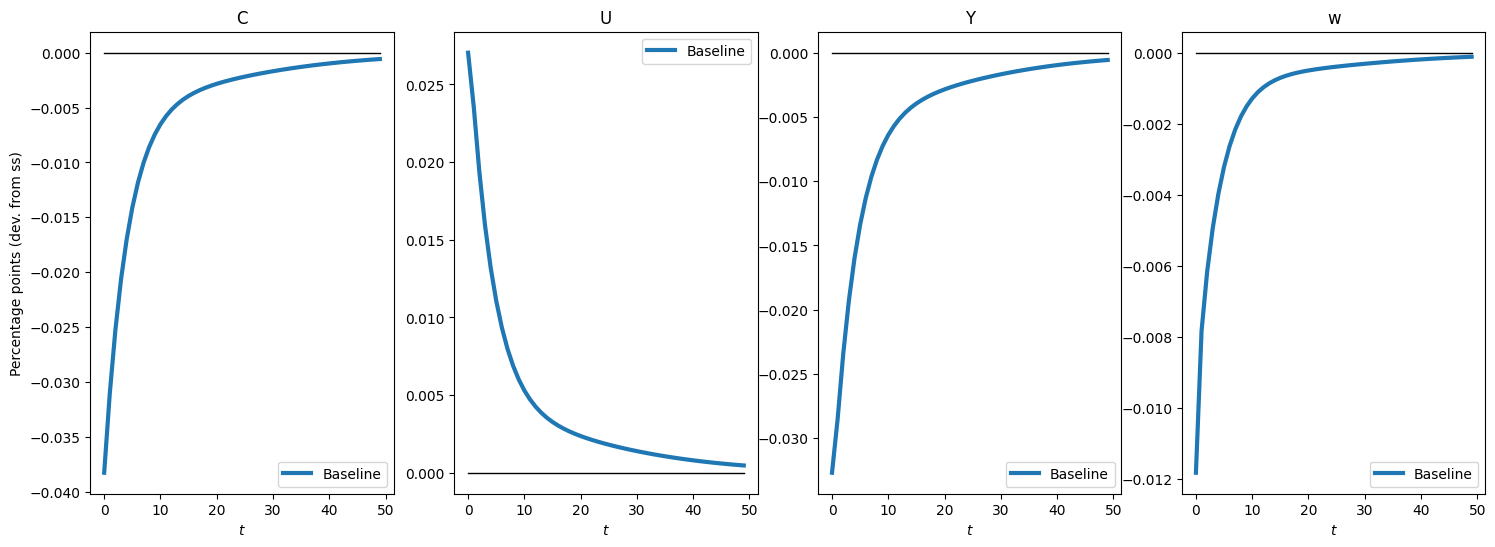

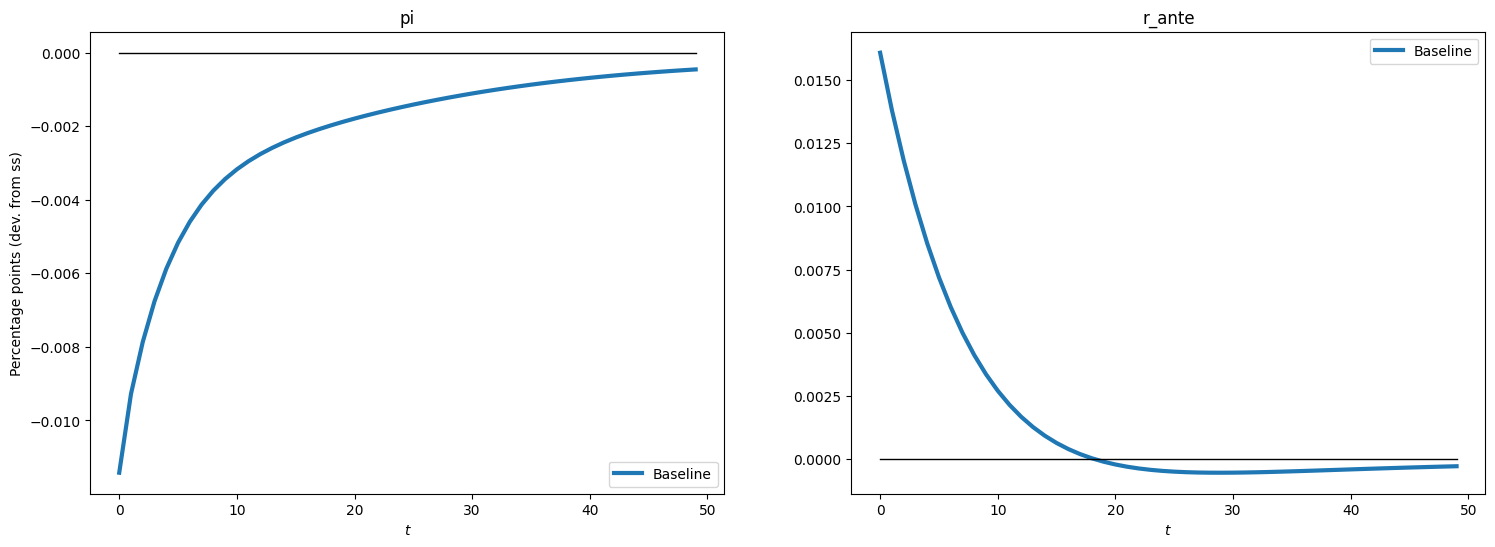

In [20]:
show_irfs([irfs_ev], ['C', 'U', 'Y', 'w'], labels=["Baseline" ])
show_irfs([irfs_ev], [  'pi','r_ante'], labels=["Baseline" ])


# Productivity Shock

In [21]:
rho_Z = .9
dZ = -Z_ss*.001 * rho_Z ** np.arange(T)

shocks_Z = {'Z': dZ}
irfs_Z = HANK_SAM.solve_impulse_linear(SteadyState_Dict, unknowns, targets, shocks_Z)


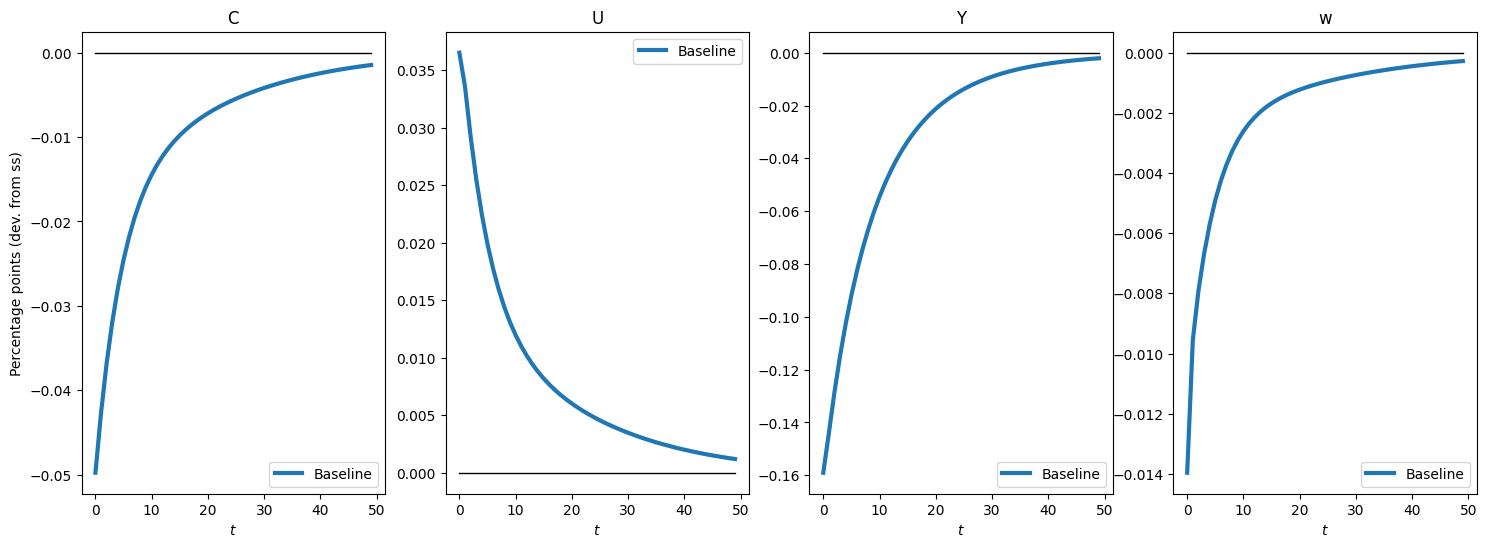

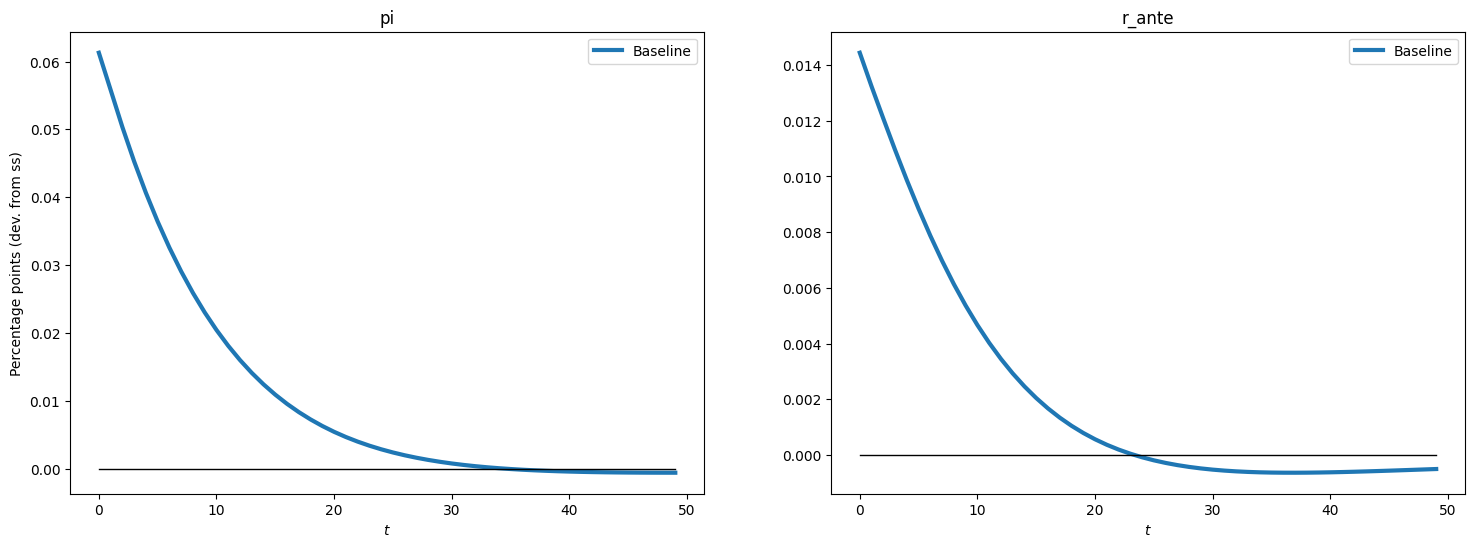

In [22]:
show_irfs([irfs_Z], ['C', 'U', 'Y', 'w'], labels=["Baseline"])
show_irfs([irfs_Z], [  'pi','r_ante'], labels=["Baseline" ])
